In [39]:
import sys
sys.path.append('../')
import numpy
import pandas
import seaborn

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs, load_sample_complete_laps
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-w7.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())

import warnings
warnings.filterwarnings('ignore')

Loaded 71 waypoints


In [40]:
# rewards.RewardW6??

In [41]:
class new_reward(rewards.RewardW7):
    
    def base_reward(self):
        return -1
    

In [42]:
factory = RewardFactory(rewards.RewardW7)
factory.rewards()

['RewardW8', 'new_reward']

In [43]:
def df_by_episode(full_df, episode_number, factory, df_to_params, reward_name='new_reward'):
    df = full_df.loc[full_df['episode']==episode_number,:].copy()
    factory.calculate_new_reward(df, track.center_line, df_to_params, reward_name, missing_params=None)
    return calculate_cumulative_reward( df,['reward',reward_name])    

def calculate_cumulative_reward(df, reward_column_names, use_stream=False):
    groupby_cols = ['iteration','episode'] + ( ['stream'] if use_stream else [] )
    cumulative_reward = df.sort_values('step').loc[:,groupby_cols + reward_column_names ].groupby(groupby_cols).cumsum()
    cumulative_reward.columns = [f'cumulative_{x}' for x in cumulative_reward.columns]
    return df.merge( cumulative_reward, left_index=True,right_index=True )

def plot_new_reward(df,reward_names):
    import seaborn

    new_df = df.loc[:,['duration','step'] + [f'cumulative_{n}' for n in reward_names] ]
    new_df = new_df.set_index('duration').sort_index()
    seaborn.lineplot(data=new_df,)
    
def summary(df,reward_names,use_stream=False, aditional_maps=None):
    aggregation_map = {'step':numpy.max,
                       'closest_waypoint_index': lambda x: x.values[0],
                       'progress':numpy.max,
                       'speed':numpy.mean,
                       'time':numpy.ptp,
                       'reward': numpy.sum,
                       'duration':numpy.max,
                      }
    aggregation_map.update({name : numpy.sum for name in reward_names })
    if aditional_maps: aggregation_map.update(aditional_maps)
    groupby_cols =  ( ['stream'] if use_stream else [] ) + ['iteration','episode'] 
    return df.groupby(groupby_cols).agg(aggregation_map)

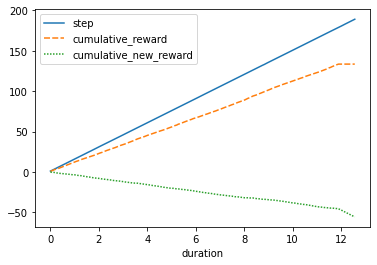

In [44]:
df = df_by_episode(full_df,1,factory,df_to_params, 'new_reward')
plot_new_reward(df,['reward','new_reward'])

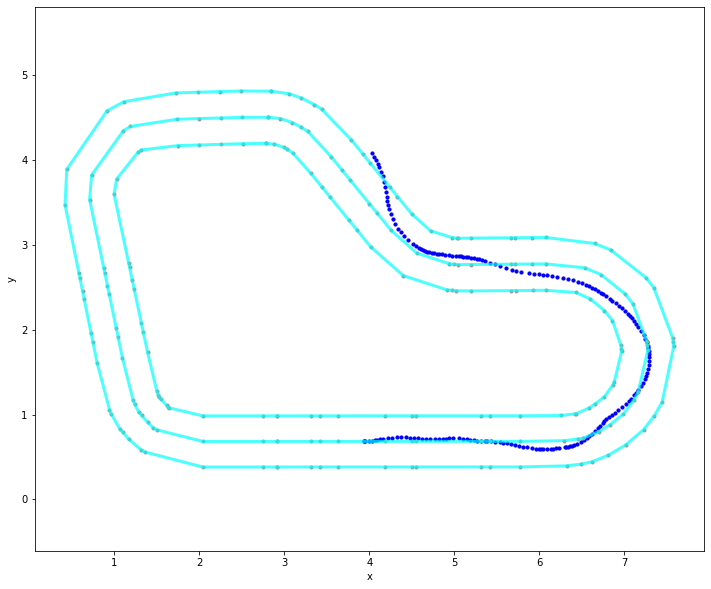

<Figure size 432x288 with 0 Axes>

In [45]:
pu.plot_selected_laps(df, new_names_df(df), track)

In [46]:
summary(df,['new_reward'])

,,step,closest_waypoint_index,progress,speed,time,reward,duration,new_reward
iteration,episode,,,,,,,,
1,1,189,34,48.9639,0.629365,00:00:12,133.469,12.568453,-55.72


# Evaluate in new_reward in sample_complete_laps

In [47]:
sample_complete_laps_path = '../logs/sample_complete_laps.csv'
scl_df = load_sample_complete_laps(sample_complete_laps_path)
calculate_iteration(scl_df)
scl_df['duration'] = scl_df[['episode','numeric_timestamp','stream']].groupby(['episode','stream']).transform(lambda x: x - x.min())
scl_df['lap_name'] = scl_df['stream'] + '_' + scl_df['episode'].astype(str)

In [48]:
factory.calculate_all_rewards(scl_df,track.center_line,df_to_params,None)

In [49]:
cum_scl = calculate_cumulative_reward( scl_df,['reward']+factory.rewards())

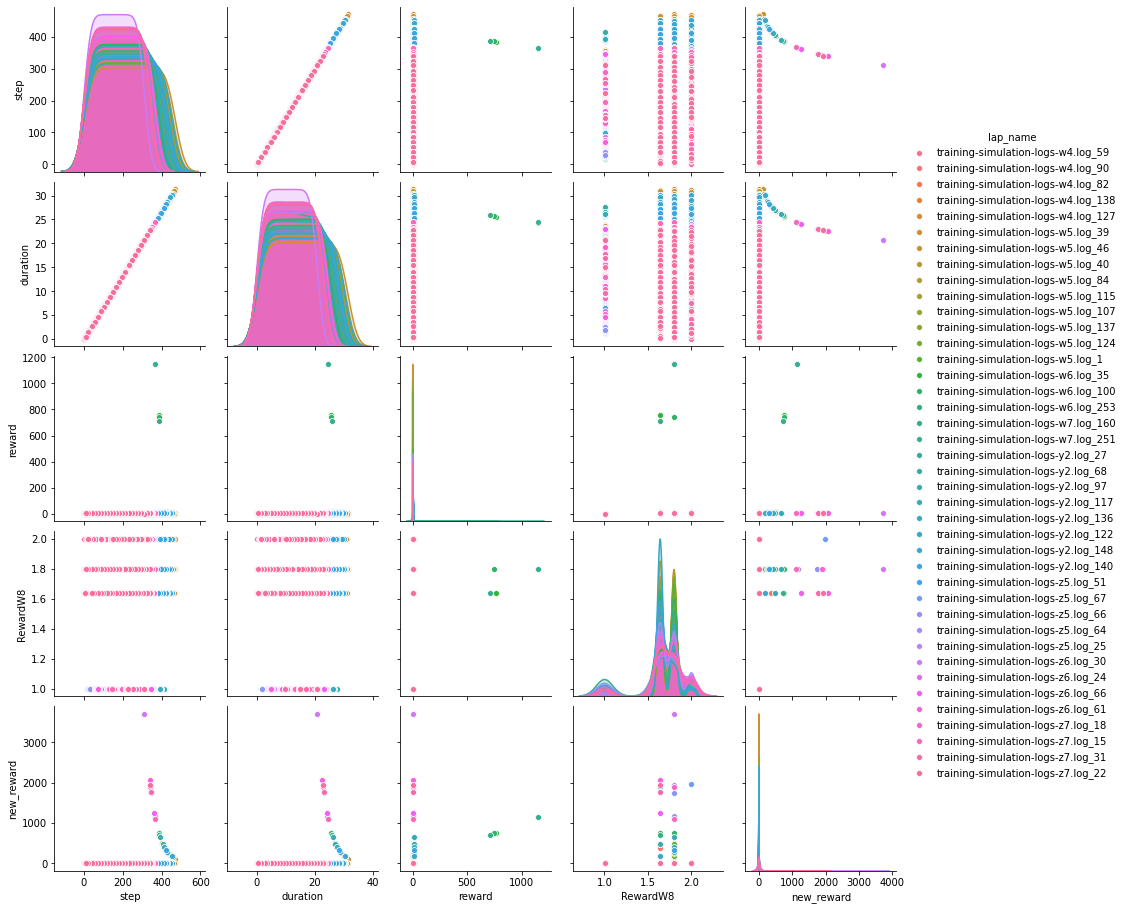

In [50]:
cols = ['step','duration','stream','lap_name'] + ['reward']+factory.rewards()
seaborn.pairplot(cum_scl[cols],hue='lap_name',palette="husl")

In [51]:
cols = ['stream','episode','time','step','stream','speed','duration','reward','new_reward', 'lap_name']
aditional_map = {'lap_name': max}
summ_scl  = summary(cum_scl,['reward','new_reward'],use_stream=True,aditional_maps=aditional_map).reset_index()[cols]

In [52]:
filtered_summ = pandas.concat( [ summ_scl.nlargest(5,'duration'),
                                summ_scl.nsmallest(5,'duration')
                               ])
filtered_summ

,stream,episode,time,step,stream,speed,duration,reward,new_reward,lap_name
6,training-simulation-logs-w5.log,39,00:00:31,470,training-simulation-logs-w5.log,0.534574,31.355924,349.8823,-6.956981,training-simulation-logs-w5.log_39
11,training-simulation-logs-w5.log,115,00:00:31,456,training-simulation-logs-w5.log,0.535373,30.390635,335.7802,33.333423,training-simulation-logs-w5.log_115
4,training-simulation-logs-w4.log,138,00:00:30,453,training-simulation-logs-w4.log,0.555099,30.200349,321.0741,31.998949,training-simulation-logs-w4.log_138
26,training-simulation-logs-y2.log,148,00:00:31,452,training-simulation-logs-y2.log,0.556615,30.179048,3334.2752,30.045292,training-simulation-logs-y2.log_148
7,training-simulation-logs-w5.log,40,00:00:30,452,training-simulation-logs-w5.log,0.536128,30.157656,341.7103,57.245292,training-simulation-logs-w5.log_40
33,training-simulation-logs-z6.log,30,00:00:20,311,training-simulation-logs-z6.log,0.719164,20.722651,1096.1986,3620.863092,training-simulation-logs-z6.log_30
34,training-simulation-logs-z6.log,61,00:00:22,338,training-simulation-logs-z6.log,0.677189,22.521142,1161.1744,1957.397510,training-simulation-logs-z6.log_61
31,training-simulation-logs-z5.log,67,00:00:23,340,training-simulation-logs-z5.log,0.684353,22.655967,1226.9454,1886.319401,training-simulation-logs-z5.log_67
27,training-simulation-logs-z5.log,25,00:00:22,341,training-simulation-logs-z5.log,0.684076,22.721786,1205.9362,1836.968007,training-simulation-logs-z5.log_25
38,training-simulation-logs-z7.log,22,00:00:22,341,training-simulation-logs-z7.log,0.673226,22.737218,846.2649,1835.448007,training-simulation-logs-z7.log_22


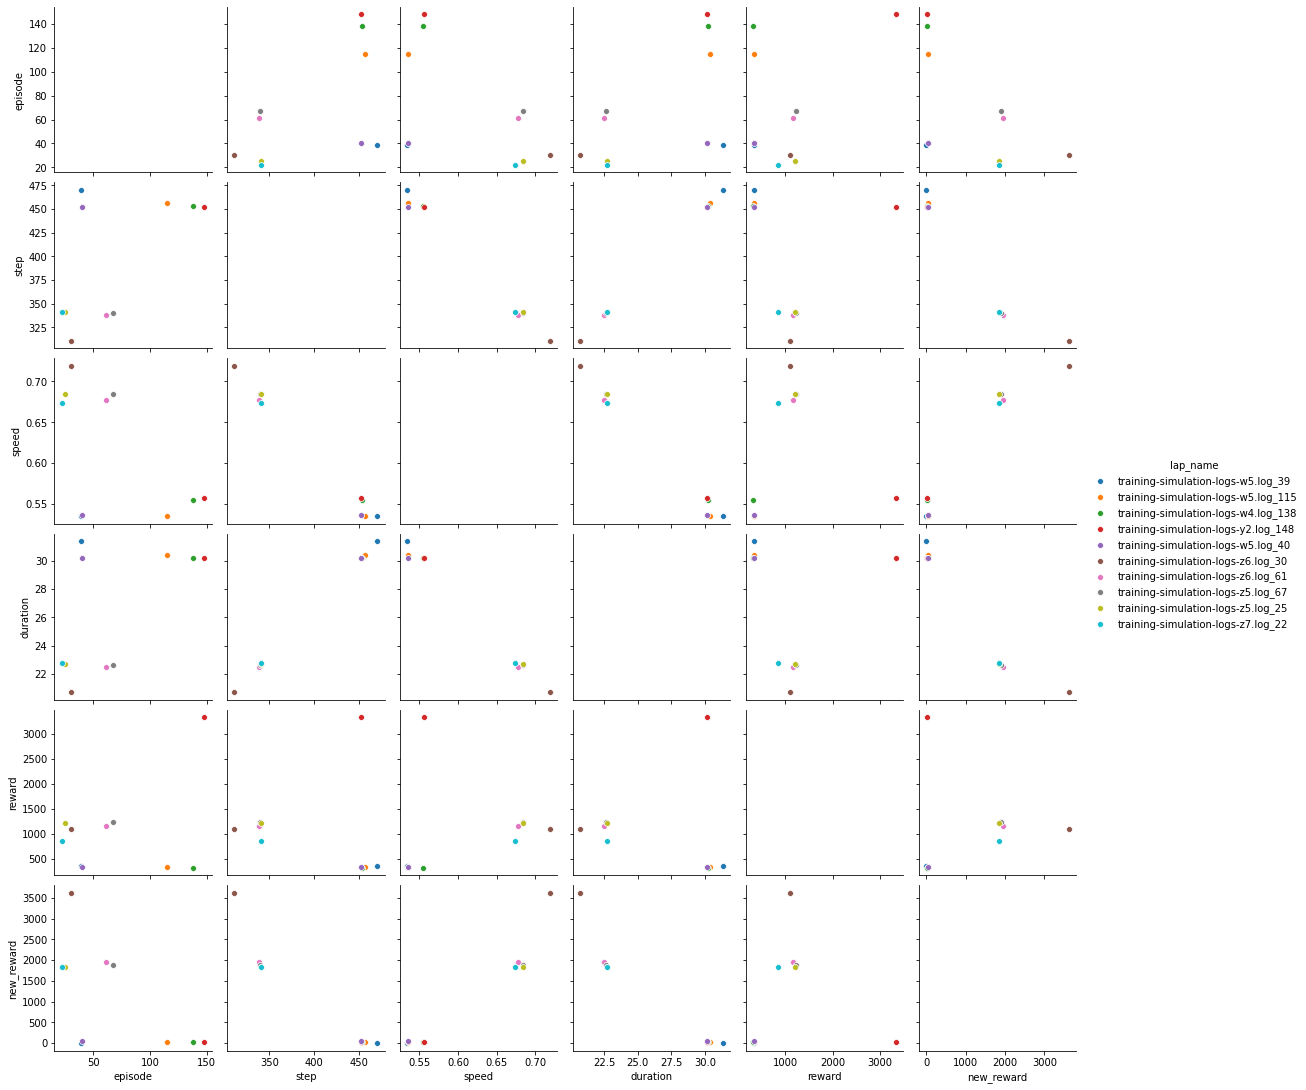

In [53]:
seaborn.pairplot(filtered_summ,hue='lap_name')

In [ ]:
seaborn.pairplot(summ_scl,hue='lap_name')